In [92]:
#Importamos algunas cosas

import numpy as np
import matplotlib.pyplot as plt

from qiskit.providers.ibmq import least_busy
import qiskit
from qiskit.visualization import plot_histogram

# Needed for functions
import time

import qiskit.quantum_info as qi
from qiskit.providers.aer import noise
from qiskit.compiler import assemble

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate

from qiskit.quantum_info import Choi, Kraus
from qiskit.extensions import HGate, XGate
import qiskit.quantum_info.operators.channel.transformations as qtrans
import itertools
import csv
import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor

from qiskit import QuantumCircuit, QuantumRegister,execute, Aer



#Definimos las matrices de Pauli
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

ImportError: cannot import name 'BaseBackend' from 'qiskit.providers' (C:\Users\tbasi\AppData\Local\Programs\Python\Python37\lib\site-packages\qiskit\providers\__init__.py)

In [15]:
# Primero iniciamos sesion
from qiskit import IBMQ
# Cargando cuenta de IBM (para realizar esto es necesaria una cuenta de IBM, preferiblemente esta sección se peude cargar desde IBM quantum lab)
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

#Entrar aqui https://quantum-computing.ibm.com/
#con el correo @ciencias para ver los trabajos enviados y demás

ibmqfactory.load_account:WARNING:2023-05-05 17:35:01,455: Credentials are already in use. The existing account in the session will be replaced.


In [16]:
qreg_q = QuantumRegister(3, 'q')  #3 registros cuánticos

circ = QuantumCircuit(qreg_q)
print(circ)

     
q_0: 
     
q_1: 
     
q_2: 
     


In [93]:
def crear_puntos(cantidad):
    '''Crear puntos en el tetraedro'''
    conjunto=[]

    #Creamos los puntos de lambdas 1, 2 y 3.
    l1s = np.linspace(-1,1,cantidad)
    l2s = np.linspace(-1,1,cantidad)
    l3s = np.linspace(-1,1,cantidad)

    #Vamos iterando sobre cada punto
    for elem in itertools.product(l1s,l2s,l3s):
        #Checamos si el punto pertenece al tetrahedro (sino, continuamos)
        if 1+elem[0]-elem[1]-elem[2]<0:
            continue
        if 1+elem[1]-elem[2]-elem[0]<0:
            continue
        if 1+elem[2]-elem[1]-elem[0]<0:
            continue
        if 1+elem[0]+elem[1]+elem[2]<0:
            continue
            
        else:
            #si pertenece, lo agregamos al conjunto de puntos
            conjunto.append(elem)
    return(conjunto)

def tomar_elemento(dic,key):
    #Función para tomar un elemento de un diccionario sin obtener error
    # si la key que se busca no existe, sino que da como resultado 0.
    if key in dic:
        return(dic[key])
    else:
        return(0)

def crear_circs(cantidad=9):
    '''Crear circuitos correspondientes a puntos en el tetraedro'''
    #Creamos la cuadricula
    conjunto = crear_puntos(cantidad)
    
    
    circuitos = []
    # Creamos los 12 circuitos de tomografia para cada punto y los ponemos
    #todos en una lista.
    for i in range(len(conjunto)):
        lambdas = conjunto[i]
        circ = lambdas_a_circ(lambdas)
        qpt_circs = process_tomography_circuits(circ,[0],prepared_qubits=[0])
        for c in qpt_circs:
            circuitos.append(c)
            
    return(circuitos)


In [94]:
import os

def correr_circs(compu,circuitos,agregar='',header=False,inicio=0):
    #Creamos una carpeta dentro de resultados, si es que no existe
    directory = "Resultados/"+compu+agregar
    if os.path.exists(directory) == False:
        os.mkdir(directory)
        
    strin = directory+"/Resultados-Binarios"+'.csv'
    if header==False:
        with open(strin,"a") as f:
            f.write("0,1")
            f.flush()

        
    repeticiones = len(circuitos)//100
    resultados = []
    qcomp=  provider.get_backend(compu)

    
    for j in range(inicio,repeticiones):
        circs = circuitos[j*100:(j+1)*100]
        job = qiskit.execute(circs,backend=qcomp, shots=20000)

        # Esto es para saber cuantos trabajos van antes en la fila y como va el nuestro
        job_monitor(job)
        
        res = job.result().get_counts()
        print("finalizado")
        #y agregamos los conteos al csv
        with open(strin,"a") as f:
            for res_i in res:
                data = [tomar_elemento(res_i,'0'),tomar_elemento(res_i,'1')]
                f.write("\n"+str(data[0])+"," + str(data[1]))
                f.flush()
                
                resultados.append(res_i)
            
    
    #Hacemos los circuitos que faltan 
    if len(circuitos) != 100*repeticiones:
        circs=circuitos[100*repeticiones:]
        job = qiskit.execute(circs,backend=qcomp, shots=20000)

        # Esto es para saber cuantos trabajos van antes en la fila y como va el nuestro
        job_monitor(job)
        
        res = job.result().get_counts()
        print(res)
        
        with open(strin,"a") as f:
            for res_u in res:
                data = [tomar_elemento(res_i,'0'),tomar_elemento(res_i,'1')]
                f.write("\n"+str(data[0])+"," + str(data[1]))
                
                resultados.append(res_i)
                f.flush()
    return(resultados)        


In [29]:
qpt_circs = ProcessTomography(circ,measurement_indices=[0],
                              preparation_indices=[0])
qpt_circs.circuits()[0]

In [31]:
circuitos =qpt_circs.circuits()
print(len(circuitos))
res = correr_circs('ibmq_lima',circuitos,'',False,0)

12
Job Status: job has successfully run
[{'0': 19881, '1': 119}, {'0': 10104, '1': 9896}, {'0': 9704, '1': 10296}, {'0': 914, '1': 19086}, {'0': 9883, '1': 10117}, {'0': 9557, '1': 10443}, {'0': 9988, '1': 10012}, {'0': 19757, '1': 243}, {'0': 9649, '1': 10351}, {'0': 10017, '1': 9983}, {'0': 10917, '1': 9083}, {'0': 19791, '1': 209}]


NameError: name 'tomar_elemento' is not defined

In [95]:
def choi_objetivo(lambdas):
    '''Para valores de las lambdas, regresa la matriz de Choi objetivo'''
    
    #Primero calculamos las alphas correspondientes
    l1,l2,l3 = lambdas
    al1 =  1/4*(1+l1-l2-l3)
    al2 = 1/4*(1-l1+l2-l3)
    al3 = 1/4*(1-l1-l2+l3)
    al0=1-al1-al2-al3
    
    #Escribimos la representación de Kraus a partir de las alphas 
    k = Kraus([np.sqrt(al0)*I,np.sqrt(al1)*X,
                               np.sqrt(al2)*Y,np.sqrt(al3)*Z])
    
    #Ahora lo convertimos a choi usando _kraus_to_choi
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(Choi(mat_choi))
choi_objetivo([0.4,0.5,0.3])

Choi([[ 0.65+0.j,  0.  +0.j,  0.  +0.j,  0.45+0.j],
      [ 0.  +0.j,  0.35+0.j, -0.05+0.j,  0.  +0.j],
      [ 0.  +0.j, -0.05+0.j,  0.35+0.j,  0.  +0.j],
      [ 0.45+0.j,  0.  +0.j,  0.  +0.j,  0.65+0.j]],
     input_dims=(2,), output_dims=(2,))

In [96]:
def rho_final(x1,x0,y1,y0,z1,z0):
    #Dados los resultados de un circuito medido en las 3 bases,
    #Calculamos la matriz de densidad del estado final creado
    total = x1+x0
    trax = (x0/total)**2 - (x1/total)**2
    tray = (y0/total)**2 - (y1/total)**2
    traz = (z0/total)**2 - (z1/total)**2
    rho = (I+trax*X+tray*Y+traz*Z)/2
    return(np.array(rho))

def tensorproduct(*args):
    """
    Calculate tensor product.

    m = tensorproduct(a,b,c,...) returns the kronecker product of its arguments.
    Each argument should either be a tensor, or a tuple containing a
    tensor and an integer, and tensor is put in zero-index slot.
    In the latter case, the integer specifies the repeat count for the tensor,
    e.g. tensorproduct(a,(b,3),c) = tensorproduct(a,b,b,b,c).

    Args:
            - args:
    Returns:
            np.ndarray: the tensor product
    """
    m_l = 1
    for j, _ in enumerate(args):
        if isinstance(args[j], tuple):
            m = args[j][0] if isinstance(args[j][0], np.ndarray) else np.asarray(args[j][0])
            for _ in range(args[j][1]):
                m_l = np.kron(m_l, m)
        else:
            m = args[j] if isinstance(args[j], np.ndarray) else np.asarray(args[j])
            m_l = np.kron(m_l, m)
    return m_l



def tomar_elemento(dic,key):
    #Función para tomar un elemento de un diccionario sin obtener error
    # si la key que se busca no existe, sino que da como resultado 0.
    if key in dic:
        return(dic[key])
    else:
        return(0)
    
    
def choi_desde_res(res):
    # Obtenemos la matriz de densidad final para los 4 estados de entrada
    #El estado 0, el estado 1, el + y el R. 
    #Los se obtienen en los 12 conteos de los circuitos qpt.
    erho0 = rho_final(tomar_elemento(res[0],'1'),tomar_elemento(res[0],'0'),
                      tomar_elemento(res[1],'1'),tomar_elemento(res[1],'0'),
                    tomar_elemento(res[2],'1'),tomar_elemento(res[2],'0'))
    
    erho1 = rho_final(tomar_elemento(res[3],'1'),tomar_elemento(res[3],'0'),
                      tomar_elemento(res[4],'1'),tomar_elemento(res[4],'0'),
                    tomar_elemento(res[5],'1'),tomar_elemento(res[5],'0'))
    
    erhomas = rho_final(tomar_elemento(res[6],'1'),tomar_elemento(res[6],'0'),
                      tomar_elemento(res[7],'1'),tomar_elemento(res[7],'0'),
                    tomar_elemento(res[8],'1'),tomar_elemento(res[8],'0'))
    
    erhoR = rho_final(tomar_elemento(res[9],'1'),tomar_elemento(res[9],'0'),
                      tomar_elemento(res[10],'1'),tomar_elemento(res[10],'0'),
                    tomar_elemento(res[11],'1'),tomar_elemento(res[11],'0'))
    
    

    #A partir de esto, calculamos la matriz de Choi
    #sumando |i><j| \otimes eps(|i><j|)
    #Los eps(|i><j|) se pueden escribir como combinación lineal de los
    # calculados en erho0, erho1, erhomas, erhoR,
    
    choi = tensorproduct(np.array([[1,0],[0,0]]),erho0)
    choi+= tensorproduct(np.array([[0,1],[0,0]]),
    erhomas+1j*erhoR-(1+1j)/2*erho0-(1+1j)/2*erho1)
    
    choi+= tensorproduct(np.array([[0,0],[1,0]]),
            erhomas-1j*erhoR-(1-1j)/2*erho1-(1-1j)/2*erho0)
    
    choi+= tensorproduct(np.array([[0,0],[0,1]]),erho1)
    
    
    return(qi.Choi(choi))

import pandas as pd

def crear_dict(df):
    d = []
    lista = np.array(df)
    for a in lista:
        d.append({'0': a[0], '1': a[1]})
    return(d)

In [98]:

import pandas as pd 
resultados_bin = pd.read_csv("Resultados/ibmq_lima-id/Resultados-Binarios.csv")
    
resul_i = resultados_bin.iloc[0:12]
d = crear_dict(resul_i)

choi_obj = choi_objetivo([0,0,0])
choi_compu = choi_desde_res(d)
    
fid =qi.process_fidelity(qi.Choi(choi_compu),target=choi_obj)
      
print(fid)
        

Input channel is not CP. Choi-matrix has negative eigenvalues: [-0.04747036 -0.00938583]


0.5049214644754013


In [52]:
Operator.tensor?

In [73]:
choi_compu

Choi([[ 0.4852  +0.j      ,  0.49405 -0.0052j  ,  0.000925+0.508025j,
        0.0257  -0.5072j  ],
      [ 0.49405 +0.0052j  ,  0.5148  +0.j      , -0.06665 +0.46915j ,
       -0.000925-0.508025j],
      [ 0.000925-0.508025j, -0.06665 -0.46915j ,  0.47785 +0.j      ,
       -0.4543  +0.00585j ],
      [ 0.0257  +0.5072j  , -0.000925+0.508025j, -0.4543  -0.00585j ,
        0.52215 +0.j      ]],
     input_dims=(2,), output_dims=(2,))

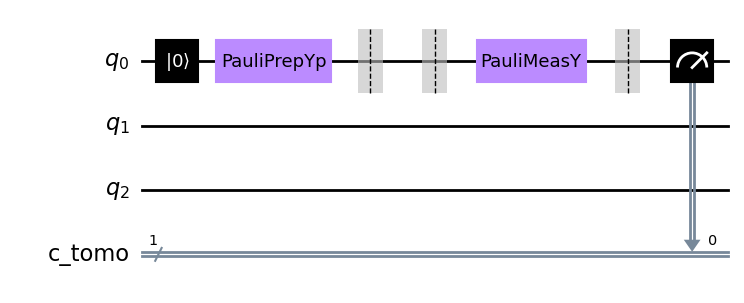

In [91]:
circuitos[11].draw("mpl")

In [99]:
choi_objetivo([0,0,0])

Choi([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j],
      [0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j],
      [0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j],
      [0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
     input_dims=(2,), output_dims=(2,))